<a href="https://colab.research.google.com/github/sundi133/chaya-ai-notebook-samples/blob/main/notebooks/colab_covid19_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [85]:
## Uncomment to install
! pip install fbprophet
! pip install chaya-ai

     |████████████████████████████████| 101 kB 10.2 MB/s 
     |████████████████████████████████| 170 kB 45.6 MB/s 
     |████████████████████████████████| 1.3 MB 34.4 MB/s 
     |████████████████████████████████| 160 kB 72.4 MB/s 
     |████████████████████████████████| 271 kB 74.2 MB/s 


In [98]:
from chaya_ai.chaya_ai import tracker 

cai = tracker() # increase collaboration and precise feedback

cai.setup(config="/content/chaya-ai-collab.json", project_name="forecasting_covidcases_sample", \
          track={"start_tag":{"keywords":"start|train"},"end_tag":{"metrics":"mean_absolute_error"}}) #use {"metrics":"mean_absolute_error|mean_squared_error"} to track both



Setup succesfull


In [99]:
# Load Python Packages
import pandas as pd
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Download .csv file from https://ourworldindata.org/coronavirus-source-data
url="https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv"
df_original = pd.read_csv(url)
df_original.head()



,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,0.126,0.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


Max/Min Date in the data

In [100]:
print(df_original.date.min())
print(df_original.date.max())


2020-01-01
2021-10-09


In [101]:

# Set variables 
country = 'United States' #TODO : 'United States','Canada', 'World'
filter_case = 'new_cases' #TODO : 'total_cases','total_deaths','new_deaths','new_cases'
period_to_forecast = 120

# Filter data
df = df_original.copy()
df = df[df['location']==country]
df.rename(columns={"date": "ds", filter_case: "y"},inplace=True) 
df['ds'] = pd.to_datetime(df['ds'],infer_datetime_format=True)
df['y'] = df['y'].astype(float)
df = df[['y','ds']]

df = df[df['ds']>"2020-02-01"] # covid cases started at this time in US
df_train =  df[df['ds']<"2021-09-07"].reset_index(drop=True)
df_test =  df[(df['ds']>="2021-09-07") & (df['ds']<"2021-10-09")].reset_index(drop=True)

print("training set size")
print(df_train.count())
print("validation set size")
print(df_test.count())


training set size
y     583
ds    583
dtype: int64
validation set size
y     32
ds    32
dtype: int64


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


23293180353.545815
134129.65284998371
/content/prophetplot.png


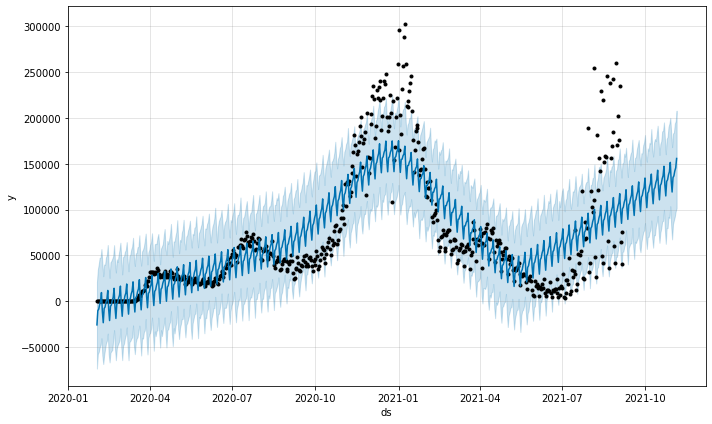

In [109]:

# Run Prophet to get predictions
cai.model_name = "prophet"
cai.save({"train":"start"})

pred = Prophet()
pred.fit(df_train)
future = pred.make_future_dataframe(periods=60)
forecast = pred.predict(future)


from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

forecast_measure = pd.merge(df_test, forecast, left_index=True, right_index=True)
forecast_measure = forecast_measure[['ds_x','yhat','y']]
mse=mean_squared_error(forecast_measure.y, forecast_measure.yhat)
mae=mean_absolute_error(forecast_measure.y, forecast_measure.yhat)
print(mse)
print(mae)

#Plot the prediction Graph
graph = pred.plot(forecast)
graph.savefig('prophetplot.png')
cai.save({"metric_type":"test", "metrics":{"mean_absolute_error":mae}})
#cai.save({"metric_type":"test", "metrics":{"mean_squared_error":mse, "mean_absolute_error":mae}})
cai.saveplot("/content/prophetplot.png")


20879257983.973656
127025.02390536154
/content/prophetplot_2.png


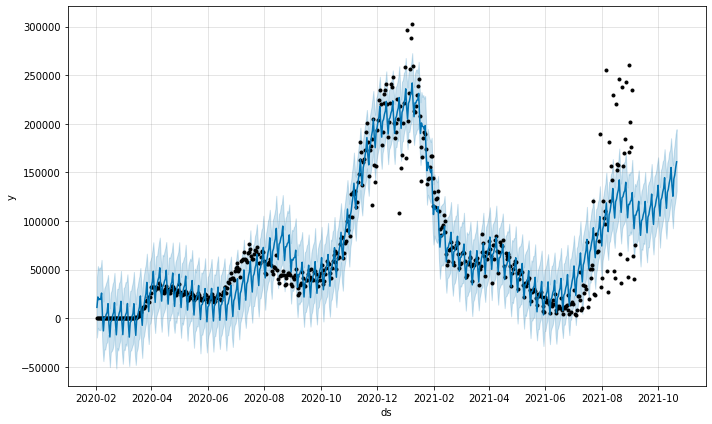

In [110]:
playoffs = pd.DataFrame({
  'holiday': 'playoff',
  'ds': pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16',
                        '2010-01-24', '2010-02-07', '2011-01-08',
                        '2013-01-12', '2014-01-12', '2014-01-19',
                        '2014-02-02', '2015-01-11', '2016-01-17',
                        '2016-01-24', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})

promotions = pd.DataFrame({
  'holiday': 'december_promotion',
  'ds': pd.to_datetime(['2009-12-01', '2010-12-01', '2011-12-01', '2012-12-01',
                        '2013-12-01', '2014-12-01','2015-12-01']),
  'lower_window': 0,
  'upper_window': 0,
})

holidays = pd.concat((playoffs, superbowls, promotions))
cai.save({"train":"start"})
pred_model_2 = Prophet(holidays=holidays, daily_seasonality=True, yearly_seasonality=True)
pred_model_2.fit(df_train)
future = pred_model_2.make_future_dataframe(periods=45)
forecast = pred_model_2.predict(future)


forecast_measure = pd.merge(df_test, forecast, left_index=True, right_index=True)
forecast_measure = forecast_measure[['ds_x','yhat','y']]
mse=mean_squared_error(forecast_measure.y, forecast_measure.yhat)
mae=mean_absolute_error(forecast_measure.y, forecast_measure.yhat)
print(mse)
print(mae)

graph.savefig('prophetplot_2.png')
cai.save({"metric_type":"test", "metrics":{"mean_absolute_error":mae}})
cai.saveplot("/content/prophetplot_2.png")

#Plot the prediction Graph
graph = pred_model_2.plot(forecast)